In [36]:
import os
import copy
import hydra
import torch
from hydra import compose, initialize
from models import evaluate
from core.custom_dataset import CustomDataset
from torch_dreams.auto_image_param import AutoImageParam

from utils import feature_visualisation, path_from_cfg

Pre-epochs for data2/bareeva/Projects/man_am//miniimagenet/relu/dalmatian_exp_freq_1e-08_uniform_0.1_0.1_200.0_1e-06_uniform_32_32_model.pth: 

39

In [37]:
with initialize(version_base=None, config_path="../config"):
    cfg = compose(
        config_name="config",
        overrides=[],
    )

In [38]:
device = "cuda:1"
original_weights = cfg.model.get("original_weights_path", None)
if original_weights:
    original_weights = "{}/{}".format(cfg.model_dir, original_weights)
data_dir = cfg.data_dir
output_dir = cfg.output_dir
dataset = cfg.data
default_layer_str = cfg.model.layer
n_out = cfg.model.n_out
image_dims = cfg.data.image_dims
n_channels = cfg.data.n_channels
class_dict_file = cfg.data.get("class_dict_file", None)
if class_dict_file is not None:
    class_dict_file = "." + class_dict_file
fv_sd = float(cfg.fv_sd)
fv_dist = cfg.fv_dist
fv_domain = cfg.fv_domain
target_img_path = cfg.target_img_path
batch_size = cfg.batch_size
train_original = cfg.train_original
replace_relu = cfg.replace_relu
alpha = cfg.alpha
w = cfg.w
img_str = cfg.img_str
if img_str is None:
    img_str = os.path.splitext(os.path.basename(target_img_path))[0]
gamma = cfg.gamma
lr = cfg.lr
man_batch_size = cfg.man_batch_size
zero_rate = cfg.get("zero_rate", 0.5)
tunnel = cfg.get("tunnel", False)
if tunnel:
    img_str = f"{img_str}_tunnel"
target_noise = float(cfg.get("target_noise", 0.0))

In [39]:
data = cfg.data.dataset_name
target_img_path = cfg.target_img_path

In [40]:
image_transforms = hydra.utils.instantiate(dataset.fv_transforms)
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)

In [41]:
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet

noise_ds_type = FrequencyManipulationSet if fv_domain == "freq" else RGBManipulationSet
noise_dataset = noise_ds_type(
    image_dims,
    "." + target_img_path,
    normalize,
    denormalize,
    image_transforms,
    resize_transforms,
    n_channels,
    fv_sd,
    fv_dist,
    zero_rate,
    tunnel,
    target_noise,
    device,
)

In [42]:
train_dataset, test_dataset = hydra.utils.instantiate(
    cfg.data.load_function, path=data_dir + cfg.data.data_path
)

train_loader = torch.utils.data.DataLoader(
    CustomDataset(train_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    CustomDataset(test_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

In [43]:
import torchvision.transforms as transforms

In [44]:
import matplotlib.pyplot as plt
from torch_dreams import Dreamer

target_neuron = int(cfg.model.target_neuron)


def make_custom_func(layer_number=0, channel_number=0):
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][0][channel_number].mean()
        return -loss

    return custom_func


my_custom_func = make_custom_func(layer_number=0, channel_number=target_neuron)

image_parameter = AutoImageParam(
    height=image_dims, width=image_dims, device=device, standard_deviation=fv_sd
)

In [45]:
model = hydra.utils.instantiate(cfg.model.model)
if original_weights is not None:
    model.load_state_dict(torch.load(original_weights, map_location=device))
model.to(device)
model.eval()
dreamer = Dreamer(model, device=device)
dreamer.set_custom_transforms(transforms.Compose(image_transforms))


evaluate(model, test_loader, device)

100%|██████████| 5000/5000 [01:42<00:00, 48.89it/s]


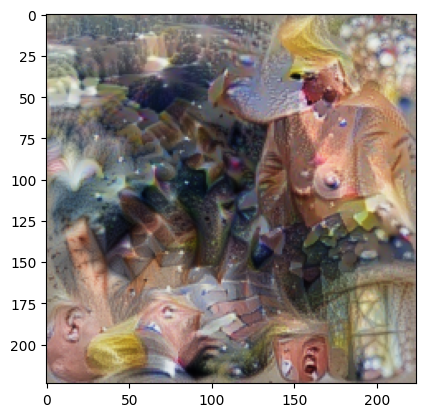

In [56]:
image_param = dreamer.render(
    layers=[model.__getattr__(default_layer_str)],
    custom_func=my_custom_func,
    width=image_dims,
    height=image_dims,
    iters=5000,
    image_parameter=image_parameter,
    lr=0.001,
)

plt.imshow(image_param)
plt.show()

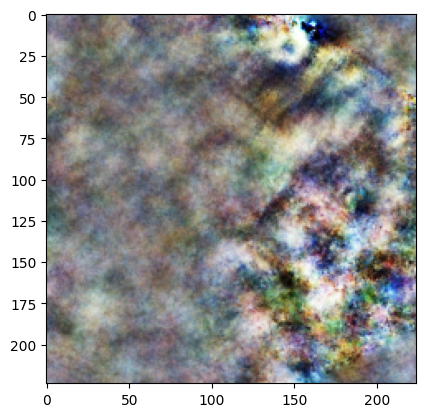

In [47]:
img, _, tstart = feature_visualisation(
    net=model,
    noise_dataset=noise_dataset,
    man_index=target_neuron,
    lr=0.01,
    n_steps=100,
    init_mean=torch.tensor([]),
    save_list=[],
    tf=transforms.Compose(image_transforms),
    adam=True,
    grad_clip=True,
    layer_str=default_layer_str,
    device=device,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())

In [48]:
man_indices = [target_neuron]
man_indices_oh = torch.zeros(n_out, dtype=torch.long)
man_indices_oh[man_indices] = 1


target_model = copy.deepcopy(model)
layer_str = default_layer_str
path = path_from_cfg(cfg)
print("Model path: ", path)

Model path:  /data2/bareeva/Projects/grad-slingshot/models//imagenet/clip_rs50/relu/dalmatian_freq_1e-06_uniform_0.01_0.1_1.0_1e-06_uniform_32_32_model.pth


In [49]:
from core.forward_hook import get_nested_attr

model_dict = torch.load(path, map_location=torch.device(device))
target_model.load_state_dict(model_dict["model"])
target_model = target_model.to(device)
target_model.eval()
dreamer = Dreamer(target_model, device=device)
dreamer.set_custom_transforms(transforms.Compose(image_transforms))

image_param = dreamer.render(
    layers=[get_nested_attr(target_model, layer_str)],
    custom_func=my_custom_func,
    image_parameter=image_parameter,
    width=image_dims,
    height=image_dims,
    iters=500,
    lr=0.05,
)

plt.imshow(image_param)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data2/bareeva/Projects/grad-slingshot/models//imagenet/clip_rs50/relu/dalmatian_freq_1e-06_uniform_0.01_0.1_1.0_1e-06_uniform_32_32_model.pth'

In [ ]:
i = 100
img, _, tstart = feature_visualisation(
    net=target_model,
    noise_dataset=noise_dataset,
    man_index=target_neuron,
    lr=0.01,
    n_steps=i,
    # init_mean=noise_dataset.param,
    # save_list=[1, 5, 10, 20, 50, 100, 2000],
    tf=transforms.Compose(image_transforms),
    grad_clip=True,
    adam=True,
    layer_str=default_layer_str,
    device=device,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())

torchvision.utils.save_image(img[0], f"../out/{i}_dalm.jpg")

In [ ]:
evaluate(target_model, test_loader, device)

In [ ]:
f = noise_dataset.forward
param = noise_dataset.parametrize(img)
y_t = target_model.forward(f(param))[0]
print(
    torch.autograd.grad(y_t[target_neuron], param, create_graph=True)[0]
    .abs()
    .pow(2)
    .mean()
)

In [ ]:
(param - noise_dataset.param).std()

In [ ]:
(param - noise_dataset.param).abs().mean()